In [7]:
from IPython.core import display
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, cross_validation
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

%matplotlib inline

In [8]:
def readCsv(name, nrows=80000):
    df = pd.read_csv(
        "data/expedia/{}.csv".format(name), 
        nrows=nrows,
        parse_dates=["date_time", "srch_ci", "srch_co"])
    df["year"] = pd.DatetimeIndex(df['date_time']).year
    df["month"] = pd.DatetimeIndex(df['date_time']).month
    df["hour"] = pd.DatetimeIndex(df['date_time']).hour
    df["dayofweek"] = pd.DatetimeIndex(df['date_time']).dayofweek
    df["hour"] = pd.DatetimeIndex(df['date_time']).hour
    
    df["srch_ci_month"] = pd.DatetimeIndex(df['srch_ci']).month
    df["srch_ci_dayofweek"] = pd.DatetimeIndex(df['srch_ci']).dayofweek
    
    df["srch_co_month"] = pd.DatetimeIndex(df['srch_co']).month
    df["srch_co_dayofweek"] = pd.DatetimeIndex(df['srch_co']).dayofweek
    
    srch_ci_utime = pd.DatetimeIndex(df['srch_ci']).astype(np.int64) // 10**9 
    srch_co_utime = pd.DatetimeIndex(df['srch_co']).astype(np.int64) // 10**9 
    
    df["srch_days"] = (srch_co_utime - srch_ci_utime) / (3600 * 24)
    
    return df

df = readCsv("train")
print("shape: ", df.shape)
df.sample(5)

('shape: ', (80000, 33))


,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,hotel_cluster,year,month,hour,dayofweek,srch_ci_month,srch_ci_dayofweek,srch_co_month,srch_co_dayofweek,srch_days
23602,2014-08-25 10:42:52,2,3,66,220,2086,438.3973,102308,0,0,...,90,2014,8,10,0,2,3,2,5,2
61008,2014-10-03 13:58:56,2,3,66,174,23578,96.2902,212547,0,0,...,55,2014,10,13,4,10,0,10,1,1
57680,2014-08-20 05:52:30,2,3,66,311,38374,146.8807,201243,0,0,...,72,2014,8,5,2,8,2,8,3,1
36590,2014-02-03 16:41:22,13,1,46,347,54921,3753.4922,141655,0,0,...,97,2014,2,16,0,3,6,3,6,7
12072,2014-06-04 22:17:56,2,3,66,174,39877,108.5843,67203,0,0,...,16,2014,6,22,2,6,5,6,6,1



### File descriptions
```
train.csv - the training set
test.csv - the test set
destinations.csv - hotel search latent attributes
sample_submission.csv - a sample submission file in the correct format
```

### Data fields

train/test.csv
```
Column name	Description	Data type
date_time	Timestamp	string
site_name	ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, ...)	int
posa_continent	ID of continent associated with site_name	int
user_location_country	The ID of the country the customer is located	int
user_location_region	The ID of the region the customer is located	int
user_location_city	The ID of the city the customer is located	int
orig_destination_distance	Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated	double
user_id	ID of user	int
is_mobile	1 when a user connected from a mobile device, 0 otherwise	tinyint
is_package	1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise	int
channel	ID of a marketing channel	int
srch_ci	Checkin date	string
srch_co	Checkout date	string
srch_adults_cnt	The number of adults specified in the hotel room	int
srch_children_cnt	The number of (extra occupancy) children specified in the hotel room	int
srch_rm_cnt	The number of hotel rooms specified in the search	int
srch_destination_id	ID of the destination where the hotel search was performed	int
srch_destination_type_id	Type of destination	int
hotel_continent	Hotel continent	int
hotel_country	Hotel country	int
hotel_market	Hotel market	int
is_booking	1 if a booking, 0 if a click	tinyint
cnt	Numer of similar events in the context of the same user session	bigint
hotel_cluster	ID of a hotel cluster	int
```

destinations.csv
```
Column name	Description	Data type
srch_destination_id	ID of the destination where the hotel search was performed	int
d1-d149	latent description of search regions	double
```

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 0 to 79999
Data columns (total 33 columns):
date_time                    80000 non-null datetime64[ns]
site_name                    80000 non-null int64
posa_continent               80000 non-null int64
user_location_country        80000 non-null int64
user_location_region         80000 non-null int64
user_location_city           80000 non-null int64
orig_destination_distance    50876 non-null float64
user_id                      80000 non-null int64
is_mobile                    80000 non-null int64
is_package                   80000 non-null int64
channel                      80000 non-null int64
srch_ci                      79945 non-null datetime64[ns]
srch_co                      79945 non-null datetime64[ns]
srch_adults_cnt              80000 non-null int64
srch_children_cnt            80000 non-null int64
srch_rm_cnt                  80000 non-null int64
srch_destination_id          80000 non-null int64
srch_destina

In [10]:
df.describe()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,hotel_cluster,year,month,hour,dayofweek,srch_ci_month,srch_ci_dayofweek,srch_co_month,srch_co_dayofweek,srch_days
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,50876.000000,80000.000000,80000.000000,80000.000000,80000.000000,...,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,79945.000000,79945.000000,79945.000000,79945.000000,80000.000000
mean,8.807575,2.663600,85.489137,305.534963,28599.680200,1877.800681,155115.520713,0.135350,0.252987,5.768013,...,49.622700,2013.721663,7.156112,13.477650,2.75190,7.180874,3.154269,7.024204,3.307987,3.373963
std,11.753027,0.727284,55.285686,205.825314,16940.860586,2096.248744,82770.616951,0.342099,0.434727,3.749953,...,28.883799,0.448183,3.288560,5.514454,1.98128,3.385170,1.890703,3.424786,2.106476,3.093980
min,2.000000,0.000000,0.000000,0.000000,3.000000,0.005600,12.000000,0.000000,0.000000,0.000000,...,0.000000,2013.000000,1.000000,0.000000,0.00000,1.000000,0.000000,1.000000,0.000000,-56.000000
25%,2.000000,3.000000,66.000000,174.000000,13951.000000,278.078100,91813.000000,0.000000,0.000000,2.000000,...,25.000000,2013.000000,4.000000,10.000000,1.00000,4.000000,2.000000,4.000000,1.000000,1.000000
50%,2.000000,3.000000,66.000000,311.000000,28400.000000,1092.930500,151494.000000,0.000000,0.000000,9.000000,...,49.000000,2014.000000,7.000000,14.000000,3.00000,8.000000,3.000000,7.000000,4.000000,3.000000
75%,11.000000,3.000000,69.000000,385.000000,43293.750000,2499.289300,206827.000000,0.000000,1.000000,9.000000,...,73.000000,2014.000000,10.000000,18.000000,4.00000,10.000000,5.000000,10.000000,5.000000,4.000000
max,53.000000,4.000000,239.000000,1025.000000,56495.000000,11641.224200,325057.000000,1.000000,1.000000,10.000000,...,99.000000,2014.000000,12.000000,23.000000,6.00000,12.000000,6.000000,12.000000,6.000000,190.000000


### Removing outliers
@TODO: explain what I am doing here.

In [11]:
print "before removing outliers :", df.shape
df = df[(df["srch_days"] < 18) & (df["srch_days"] > -1)]
print "after removing outliers :", df.shape

before removing outliers : (80000, 33)
after removing outliers : (79714, 33)


### Treating Missing values

In [12]:
def removeMisingvalues(df):
    """
    remove data rows associated with any missing value
    """
    return df[
        df.orig_destination_distance.notnull() &
        df.srch_ci.notnull()
    ]

print "before removing missing values :", df.shape
df = removeMisingvalues(df)
print "after removing missing values :", df.shape

before removing missing values : (79714, 33)
after removing missing values : (50660, 33)


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50660 entries, 0 to 79999
Data columns (total 33 columns):
date_time                    50660 non-null datetime64[ns]
site_name                    50660 non-null int64
posa_continent               50660 non-null int64
user_location_country        50660 non-null int64
user_location_region         50660 non-null int64
user_location_city           50660 non-null int64
orig_destination_distance    50660 non-null float64
user_id                      50660 non-null int64
is_mobile                    50660 non-null int64
is_package                   50660 non-null int64
channel                      50660 non-null int64
srch_ci                      50660 non-null datetime64[ns]
srch_co                      50660 non-null datetime64[ns]
srch_adults_cnt              50660 non-null int64
srch_children_cnt            50660 non-null int64
srch_rm_cnt                  50660 non-null int64
srch_destination_id          50660 non-null int64
srch_destina

### Data exploration


-------------------------
Column: srch_days

count    50660.000000
mean         3.216739
std          2.527147
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         17.000000
Name: srch_days, dtype: float64


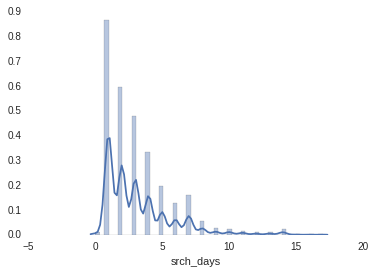

In [14]:
def exploreUnivariate(column):
    print "\n-------------------------\nColumn: {}\n".format(column.name)
    print column.describe()
    try:
        sns.distplot(column)
    except:
        print "cannot be plotted"
    plt.show()
exploreUnivariate(df["srch_days"])
# exploreUnivariate(np.log(df["srch_days"]))  # less skewness


-------------------------
Column: srch_ci_dayofweek

count    50660.000000
mean         3.170095
std          1.873037
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max          6.000000
Name: srch_ci_dayofweek, dtype: float64


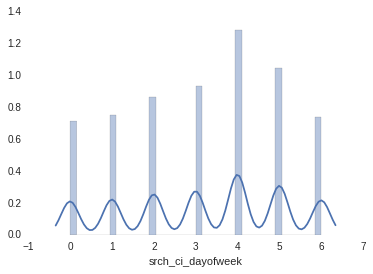

In [15]:
exploreUnivariate(df["srch_ci_dayofweek"])


-------------------------
Column: site_name

count    50660.000000
mean         4.614982
std          6.813524
min          2.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         40.000000
Name: site_name, dtype: float64


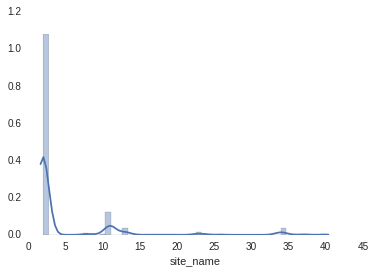


-------------------------
Column: posa_continent

count    50660.000000
mean         2.908251
std          0.454867
min          0.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: posa_continent, dtype: float64


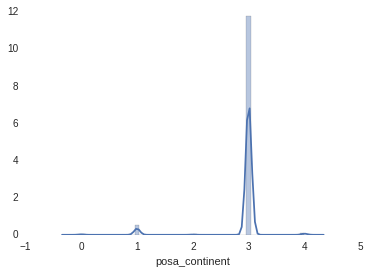


-------------------------
Column: user_location_country

count    50660.000000
mean        83.594730
std         48.972222
min          0.000000
25%         66.000000
50%         66.000000
75%         66.000000
max        215.000000
Name: user_location_country, dtype: float64


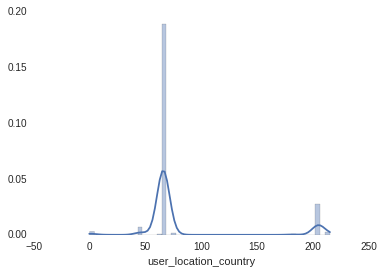


-------------------------
Column: user_location_region

count    50660.000000
mean       295.364390
std        126.759431
min        135.000000
25%        174.000000
50%        311.000000
75%        356.000000
max       1017.000000
Name: user_location_region, dtype: float64


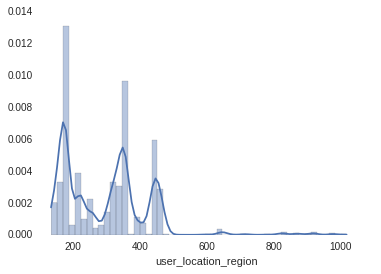


-------------------------
Column: user_location_city

count    50660.000000
mean     29407.224655
std      16888.600461
min          3.000000
25%      15257.000000
50%      28643.000000
75%      45689.000000
max      56472.000000
Name: user_location_city, dtype: float64


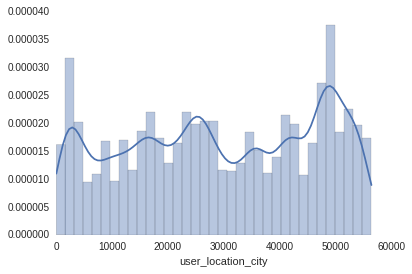


-------------------------
Column: orig_destination_distance

count    50660.000000
mean      1872.299175
std       2092.653568
min          0.005600
25%        277.061500
50%       1089.835000
75%       2479.008000
max      11641.224200
Name: orig_destination_distance, dtype: float64


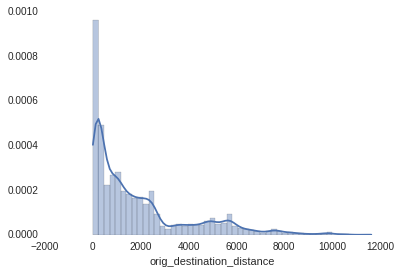


-------------------------
Column: user_id

count     50660.000000
mean     158953.157462
std       84193.536639
min          12.000000
25%       94390.000000
50%      152758.000000
75%      215222.000000
max      325057.000000
Name: user_id, dtype: float64


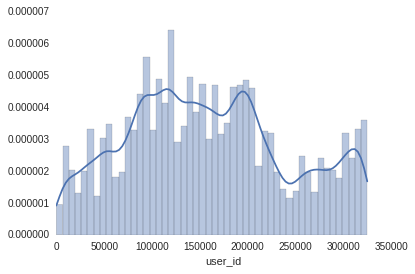


-------------------------
Column: is_mobile

count    50660.000000
mean         0.129589
std          0.335854
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: is_mobile, dtype: float64


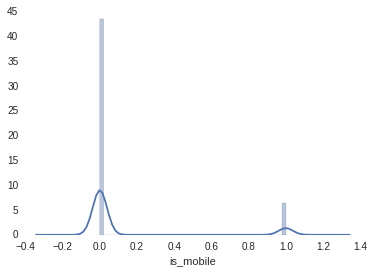


-------------------------
Column: is_package

count    50660.000000
mean         0.238946
std          0.426444
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: is_package, dtype: float64


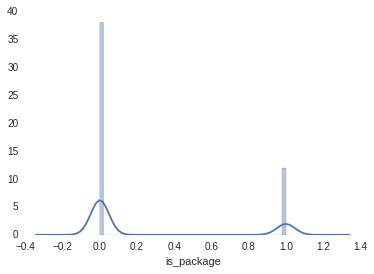


-------------------------
Column: channel

count    50660.000000
mean         5.790959
std          3.792164
min          0.000000
25%          2.000000
50%          9.000000
75%          9.000000
max         10.000000
Name: channel, dtype: float64


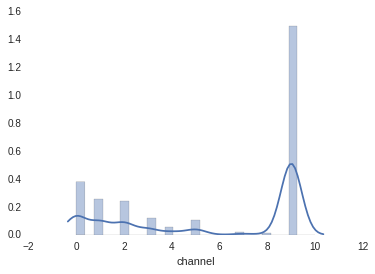


-------------------------
Column: srch_ci

count                   50660
unique                    973
top       2014-12-26 00:00:00
freq                      335
first     2013-01-08 00:00:00
last      2015-12-28 00:00:00
Name: srch_ci, dtype: object
cannot be plotted


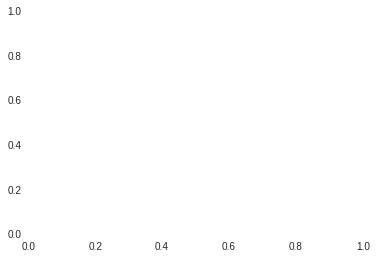


-------------------------
Column: srch_co

count                   50660
unique                    985
top       2014-11-30 00:00:00
freq                      377
first     2013-01-10 00:00:00
last      2016-01-02 00:00:00
Name: srch_co, dtype: object
cannot be plotted


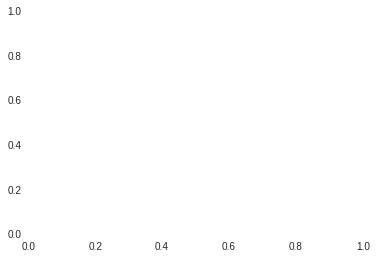


-------------------------
Column: srch_adults_cnt

count    50660.000000
mean         2.032610
std          0.898819
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          9.000000
Name: srch_adults_cnt, dtype: float64


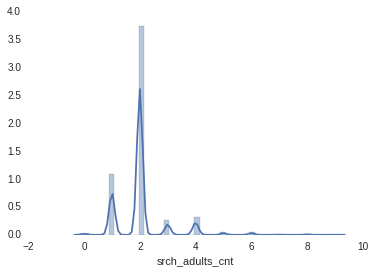


-------------------------
Column: srch_children_cnt

count    50660.000000
mean         0.355251
std          0.764105
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          9.000000
Name: srch_children_cnt, dtype: float64


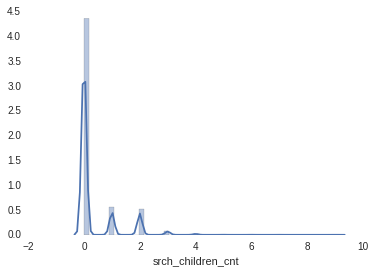


-------------------------
Column: srch_rm_cnt

count    50660.000000
mean         1.102685
std          0.451344
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: srch_rm_cnt, dtype: float64


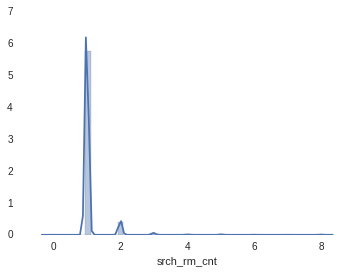


-------------------------
Column: srch_destination_id

count    50660.000000
mean     14595.987979
std      10911.394489
min         11.000000
25%       8267.000000
50%      11373.000000
75%      17859.000000
max      64999.000000
Name: srch_destination_id, dtype: float64


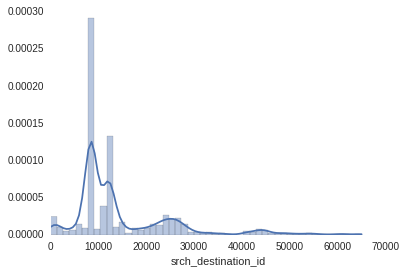


-------------------------
Column: srch_destination_type_id

count    50660.000000
mean         2.702329
std          2.187003
min          1.000000
25%          1.000000
50%          1.000000
75%          5.000000
max          8.000000
Name: srch_destination_type_id, dtype: float64


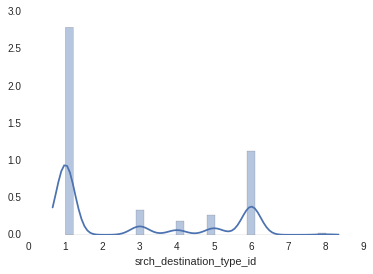


-------------------------
Column: is_booking

count    50660.000000
mean         0.086281
std          0.280781
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: is_booking, dtype: float64


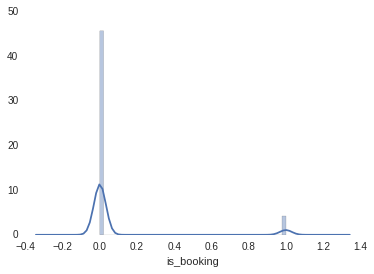


-------------------------
Column: cnt

count    50660.000000
mean         1.465377
std          1.149878
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         44.000000
Name: cnt, dtype: float64


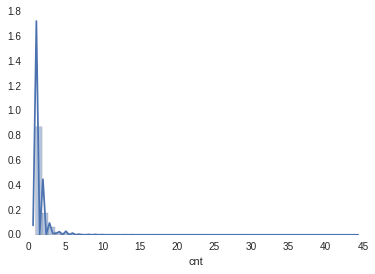


-------------------------
Column: hotel_continent

count    50660.000000
mean         2.908606
std          1.481022
min          0.000000
25%          2.000000
50%          2.000000
75%          4.000000
max          6.000000
Name: hotel_continent, dtype: float64


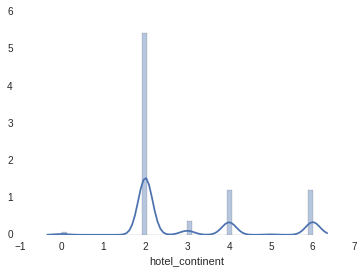


-------------------------
Column: hotel_country

count    50660.000000
mean        72.064193
std         52.170659
min          0.000000
25%         50.000000
50%         50.000000
75%         70.000000
max        212.000000
Name: hotel_country, dtype: float64


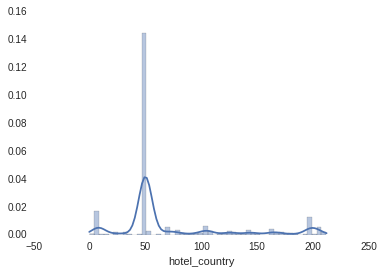


-------------------------
Column: hotel_market

count    50660.000000
mean       620.883794
std        463.650465
min          0.000000
25%        253.000000
50%        628.000000
75%        701.000000
max       2117.000000
Name: hotel_market, dtype: float64


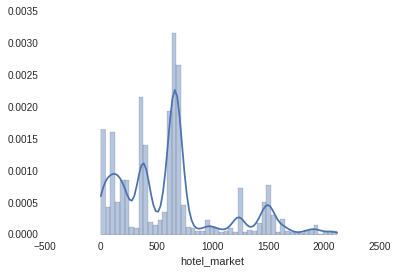


-------------------------
Column: hotel_cluster

count    50660.000000
mean        49.616976
std         29.113516
min          0.000000
25%         25.000000
50%         48.000000
75%         73.000000
max         99.000000
Name: hotel_cluster, dtype: float64


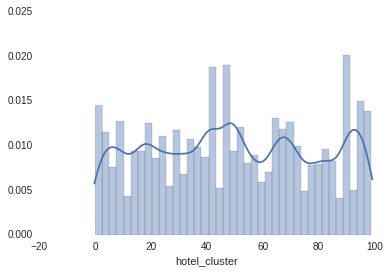


-------------------------
Column: year

count    50660.000000
mean      2013.716423
std          0.450738
min       2013.000000
25%       2013.000000
50%       2014.000000
75%       2014.000000
max       2014.000000
Name: year, dtype: float64


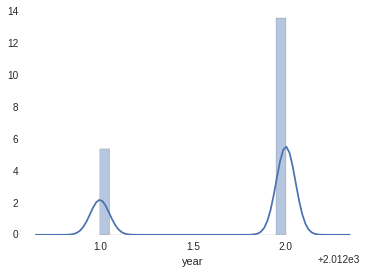


-------------------------
Column: month

count    50660.000000
mean         7.054106
std          3.302721
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: month, dtype: float64


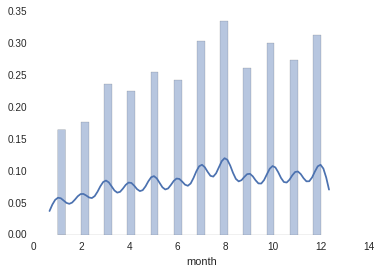


-------------------------
Column: hour

count    50660.000000
mean        13.652665
std          5.243152
min          0.000000
25%         10.000000
50%         14.000000
75%         18.000000
max         23.000000
Name: hour, dtype: float64


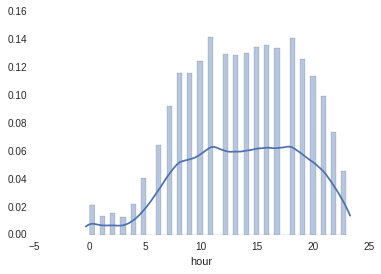


-------------------------
Column: dayofweek

count    50660.000000
mean         2.705843
std          1.962289
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: dayofweek, dtype: float64


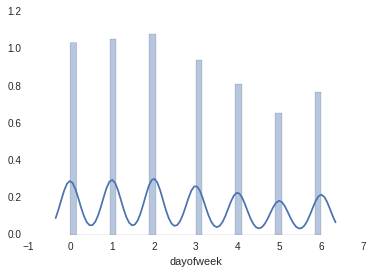


-------------------------
Column: srch_ci_month

count    50660.000000
mean         7.133893
std          3.355605
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: srch_ci_month, dtype: float64


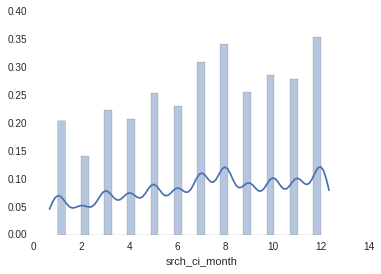


-------------------------
Column: srch_ci_dayofweek

count    50660.000000
mean         3.170095
std          1.873037
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max          6.000000
Name: srch_ci_dayofweek, dtype: float64


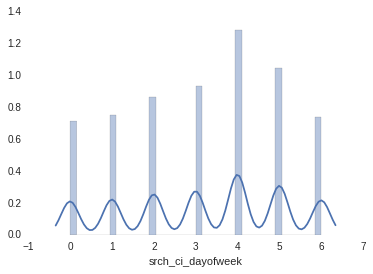


-------------------------
Column: srch_co_month

count    50660.000000
mean         6.999961
std          3.390244
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: srch_co_month, dtype: float64


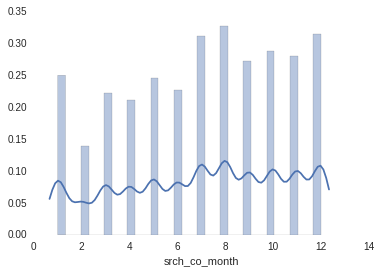


-------------------------
Column: srch_co_dayofweek

count    50660.000000
mean         3.385373
std          2.123096
min          0.000000
25%          2.000000
50%          4.000000
75%          5.000000
max          6.000000
Name: srch_co_dayofweek, dtype: float64


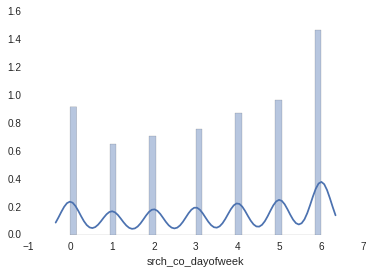


-------------------------
Column: srch_days

count    50660.000000
mean         3.216739
std          2.527147
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         17.000000
Name: srch_days, dtype: float64


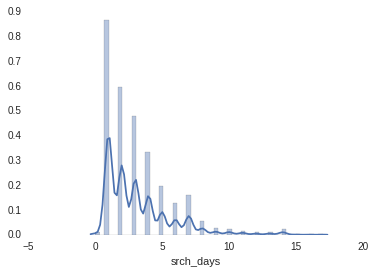

In [16]:
for i in df.drop(labels=["date_time"], axis=1).columns:
    exploreUnivariate(df[i])

In [17]:
# @TODO: plot bivariate charts

KeyboardInterrupt: 

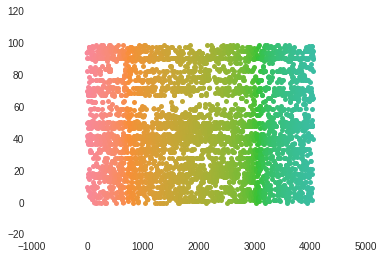

In [25]:
sns.stripplot(x="orig_destination_distance", y="hotel_cluster", data=df.sample(10000))

In [ ]:
cols = [u'site_name', u'posa_continent', u'user_location_country',
       u'user_location_region', u'user_location_city', u'is_mobile', u'is_package',
       u'channel', u'srch_ci', u'srch_co', u'srch_adults_cnt',
       u'srch_children_cnt', u'srch_rm_cnt', u'srch_destination_id',
       u'srch_destination_type_id', u'is_booking', u'cnt', u'hotel_continent',
       u'hotel_country', u'hotel_market', u'hotel_cluster', u'year', u'month',
       u'hour', u'dayofweek', u'srch_ci_month', u'srch_ci_dayofweek',
       u'srch_co_month', u'srch_co_dayofweek', u'srch_days']

for i in cols:
    sns.boxplot(x=i, y="hotel_cluster", data=df)
    plt.show()


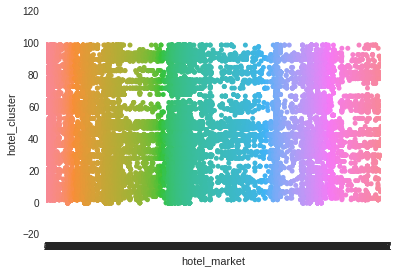

In [54]:
sns.stripplot(x="hotel_market", y="hotel_cluster", data=df, jitter=True)

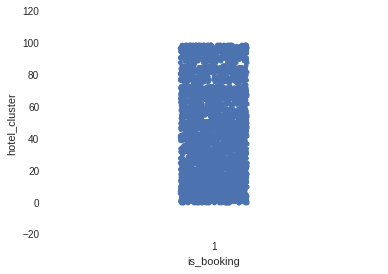

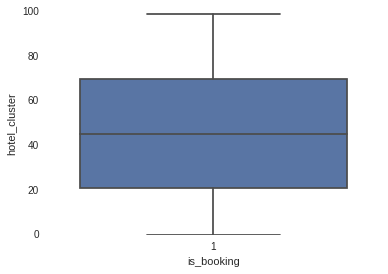

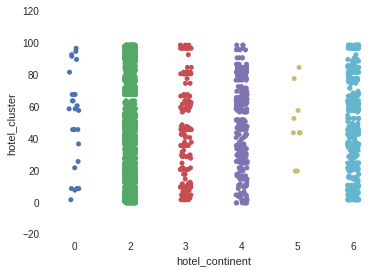

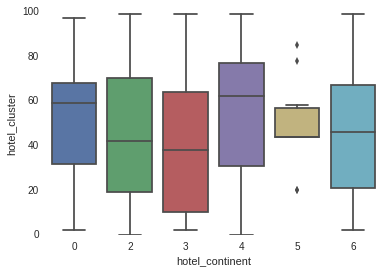

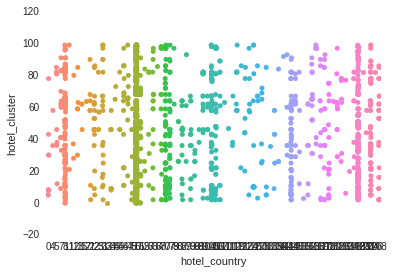

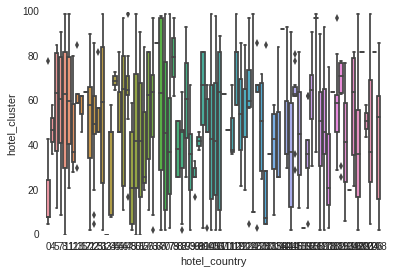

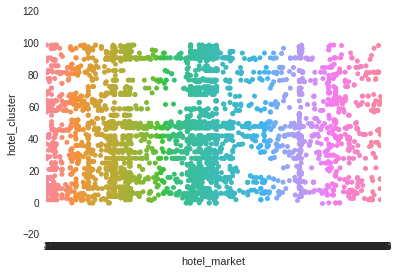

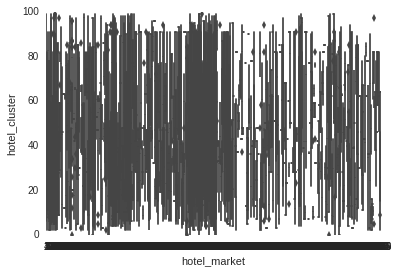

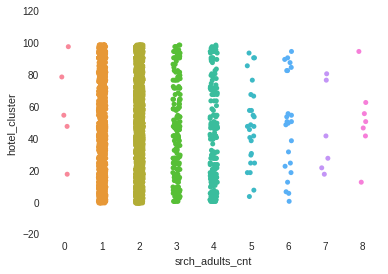

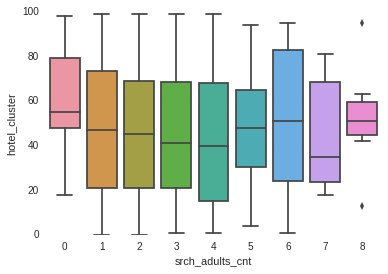

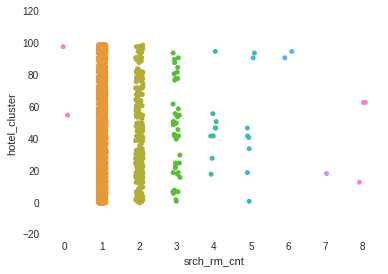

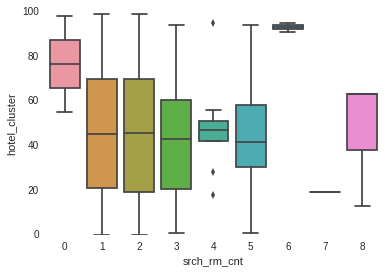

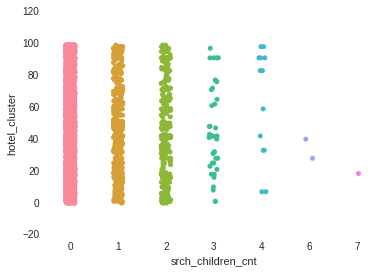

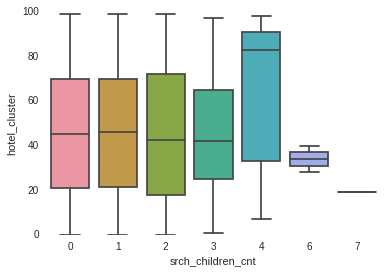

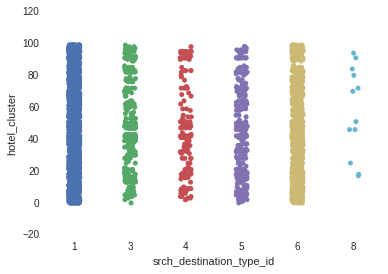

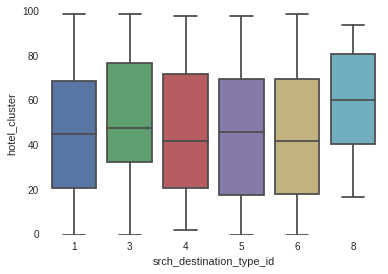

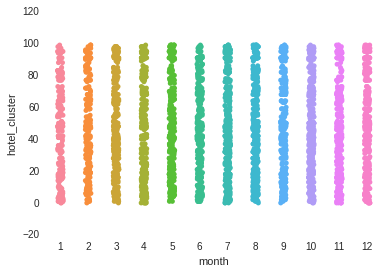

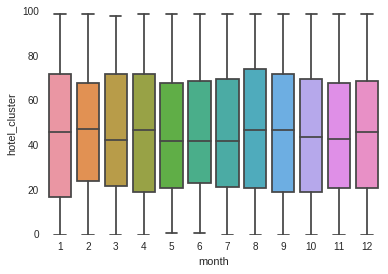

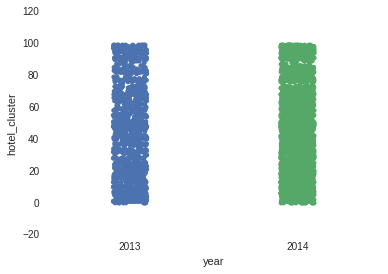

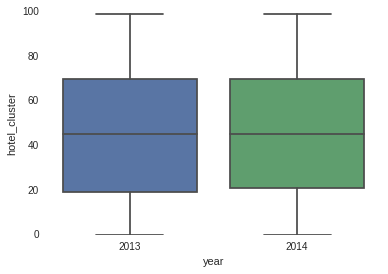

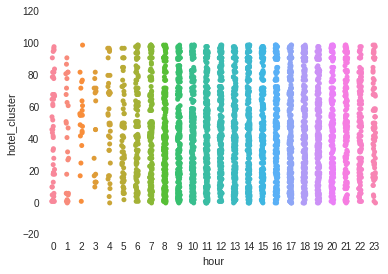

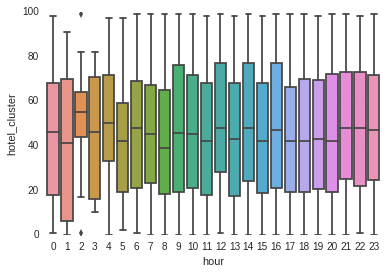

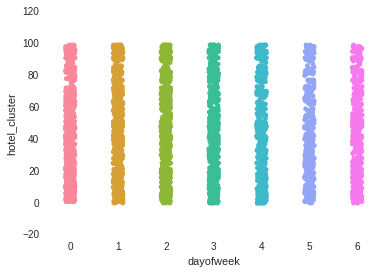

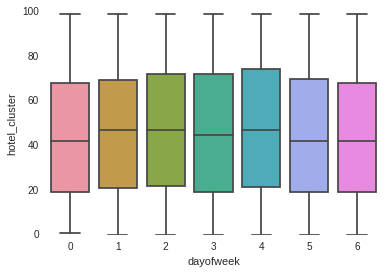

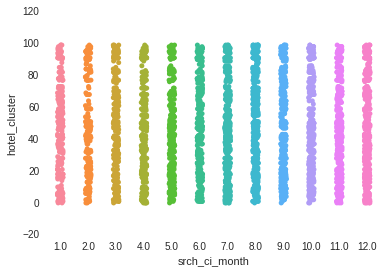

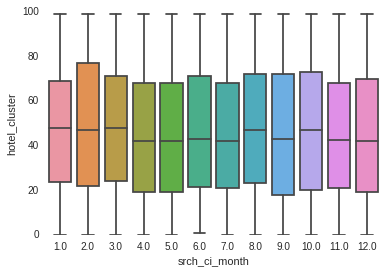

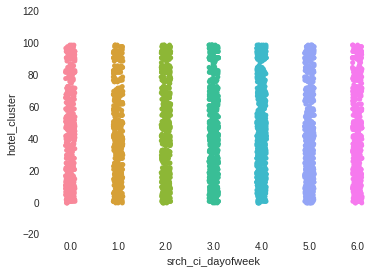

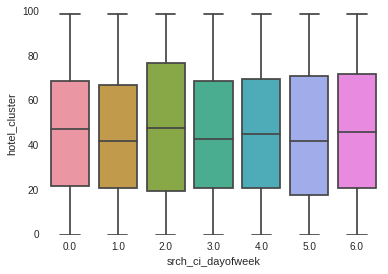

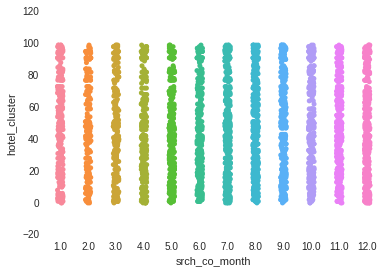

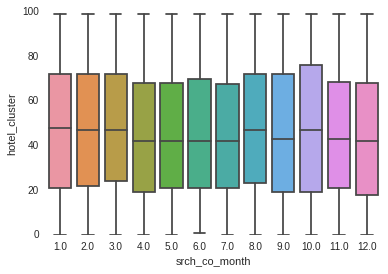

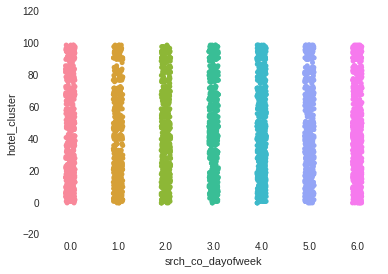

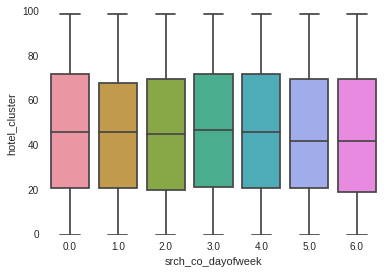

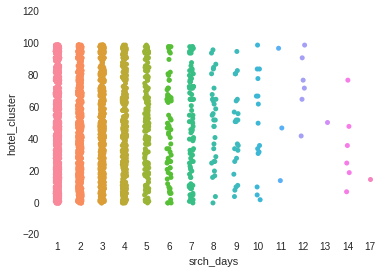

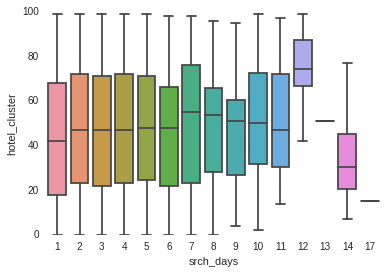

In [66]:
def biVariate(df):
    cols = [
        "is_booking", 
        "hotel_continent", "hotel_country", "hotel_market",
        "srch_adults_cnt", "srch_rm_cnt", "srch_children_cnt", 
        "srch_destination_type_id", 
        "month", "year", "hour", "dayofweek", "srch_ci_month", 
        "srch_ci_dayofweek", "srch_co_month", "srch_co_dayofweek", "srch_days"]
    for i in cols:
        sns.stripplot(x=i, y="hotel_cluster", data=df, jitter=True)
        plt.show()
        sns.boxplot(x=i, y="hotel_cluster", data=df)
        plt.show()
biVariate(df[df.is_booking == 1])

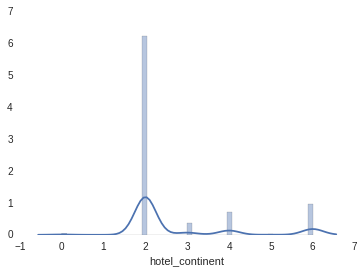

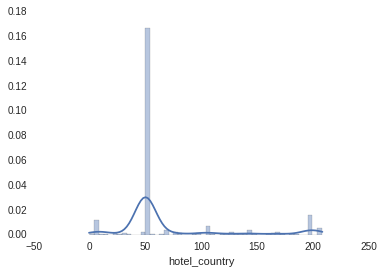

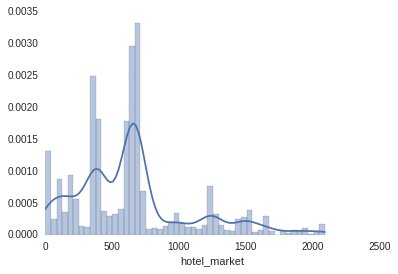

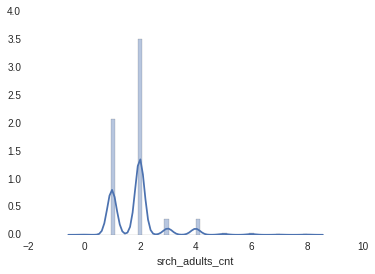

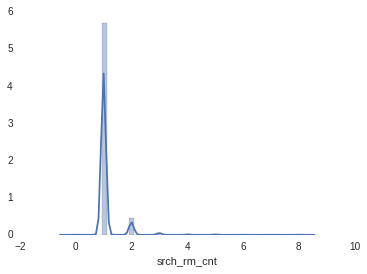

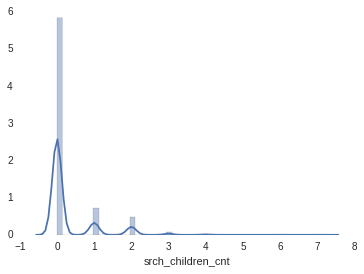

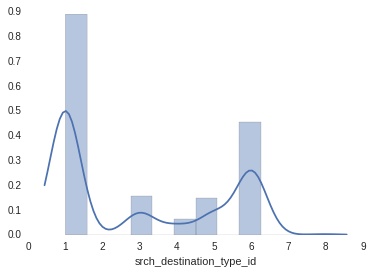

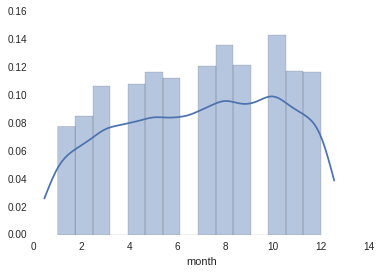

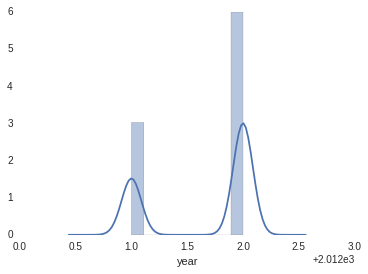

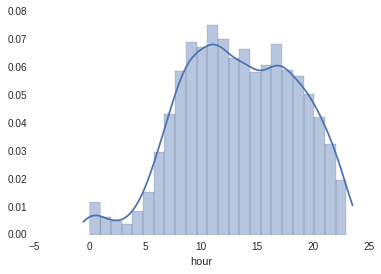

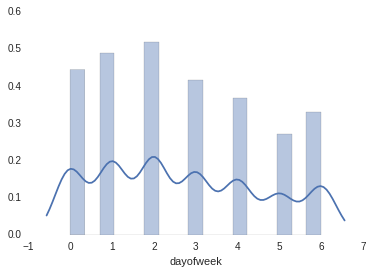

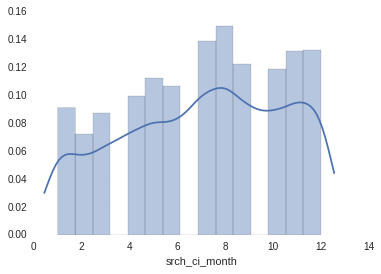

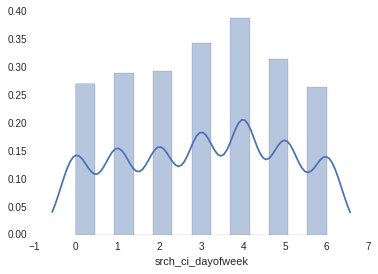

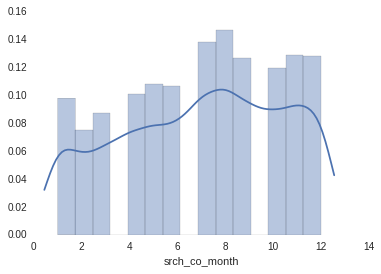

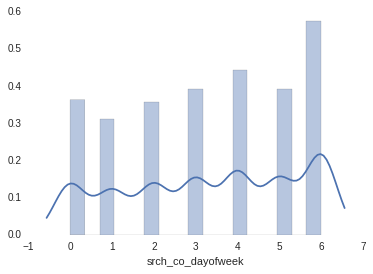

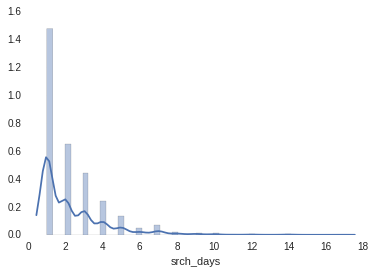

In [73]:
def biVariate2(df):
    cols = [
        "hotel_continent", "hotel_country", "hotel_market",
        "srch_adults_cnt", "srch_rm_cnt", "srch_children_cnt", 
        "srch_destination_type_id", 
        "month", "year", "hour", "dayofweek", "srch_ci_month", 
        "srch_ci_dayofweek", "srch_co_month", "srch_co_dayofweek", "srch_days"]
    for i in cols:
        sns.distplot(df[i])
        plt.show()
biVariate2(df[df.is_booking == 1])